# Assignment 3

*Salim M'jahad - msm2243*

### Intro to Theoretical Neuroscience

#### **Problem 1**

In [0]:
import numpy as np 
import matplotlib.pyplot as plt

# Hodgin-Huxley model
# We use milli-sec, mV, nA, nF, mega Ohm 

c_m = 10.0

V_0 = -65.0
m_0 = 0.0529
h_0 = 0.5961
n_0 = 0.3177

g_L = 0.003*1000
g_K = 0.36*1000
g_Na = 1.2*1000

E_L = -54.387
E_K = -77
E_Na = 50

E_vec = np.array([E_L, E_K, E_Na])

class HHModel:
  def __init__(self, duration, step_size, I_e_over_A):
    # duration: duration in ms
    # step_size: delta t in ms
    # I_e_over_A: vector representing external current at each time
    self.duration = duration
    self.step_size = step_size
    self.I_e_over_A = I_e_over_A
    self.steps = np.ceil(duration/step_size).astype(int)
    assert np.size(self.I_e_over_A) == self.steps+1
    self.V = np.zeros(self.steps+1)
    self.NMH = np.zeros((self.steps+1, 3))
    self.g_vec = None
    self.g_vec_sum = None
    self.V[0] = V_0
    self.NMH[0] = np.array([n_0, m_0, h_0])
    self.t_range = np.arange(self.steps+1)*self.step_size
    self.firing_rate = None
  
  def calc_g_vec(self, stp):
    self.g_vec = np.array([g_L, g_K*(self.NMH[stp, 0]**4), g_Na*(self.NMH[stp,1]**3)*self.NMH[stp,2]])
    self.g_vec_sum = self.g_vec.sum()

  def tau_V(self):
    return c_m/self.g_vec_sum

  def c(self, stp):
    return (E_vec.dot(self.g_vec)+self.I_e_over_A[stp])/self.g_vec_sum

  def alpha_n(self, stp):
    return 0.01*(self.V[stp-1]+55.0)/(1.0-np.exp(-0.1*(self.V[stp-1]+55.0)))
  
  def alpha_m(self, stp):
    return 0.1*(self.V[stp-1]+40.0)/(1.0-np.exp(-0.1*(self.V[stp-1]+40.0)))

  def alpha_h(self, stp):
    return 0.07*np.exp(-0.05*(self.V[stp-1]+65.0))

  def beta_n(self, stp):
    return 0.125*(np.exp(-0.0125*(self.V[stp-1]+65.0)))

  def beta_m(self, stp):
    return 4.0*np.exp(-0.0556*(self.V[stp-1]+65.0))
  
  def beta_h(self, stp):
    return 1.0/(1.0+np.exp(-0.1*(self.V[stp-1]+35.0)))

  def calc_N_M_H(self, stp):
    alpha = np.array([self.alpha_n(stp), self.alpha_m(stp), self.alpha_h(stp)]) #n,m,h
    beta = np.array([self.beta_n(stp), self.beta_m(stp), self.beta_h(stp)])
    tau = 1.0/(alpha+beta)
    inf = alpha*tau
    self.NMH[stp] = inf + (self.NMH[stp-1] - inf)*np.exp(-self.step_size/tau)

  def calc_V(self, stp):
    self.calc_g_vec(stp)
    self.V[stp] = (self.c(stp) + (self.V[stp-1] - self.c(stp))*np.exp(-self.step_size/self.tau_V()))
  
  def integrate_exp(self):
    step_range = np.arange(self.steps+1)
    self.firing_rate = 0
    for stp in step_range[1:]:
      self.calc_N_M_H(stp)
      self.calc_V(stp)

  def plot(self):
    plt.plot(self.t_range,hhmodel.V)
    plt.title('V in mV')
    plt.show()
    plt.plot(self.t_range,self.NMH[:,0])
    plt.plot(self.t_range,self.NMH[:,1])
    plt.plot(self.t_range,self.NMH[:,2])
    plt.title('N (blue) M (orange) H (green)')
    plt.show()

a) Using external current I_e/A = 200 nA/mm^2

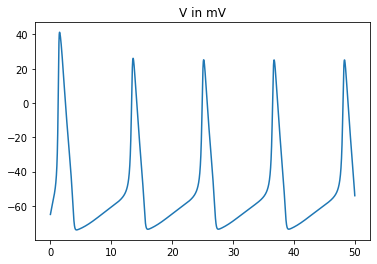

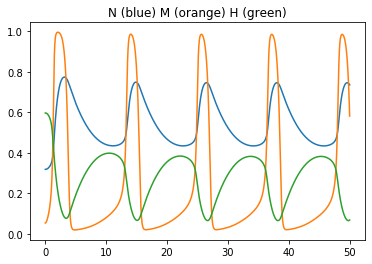

In [0]:
duration = 50.0 #ms
time_step = 0.01 #ms
I_e_over_A = np.full(np.ceil(duration/time_step).astype(int)+1, 200.0)
hhmodel = HHModel(duration, time_step, I_e_over_A)
hhmodel.integrate_exp()
hhmodel.plot()

b) Plot the firing rate of the model as a function of Ie/A over the range from 0 to 500 nA/mm2


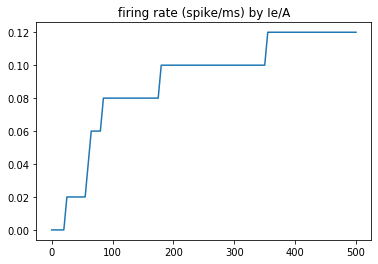

In [0]:
from scipy.signal import find_peaks

# I set 0 as a threshold for the peak to avoid pseudo-peaks to confuse the 
# signal processing peak counter
def firing_rate(V_seq, duration):
  V_seq = np.maximum(V_seq, 0)
  return len(find_peaks(V_seq)[0])/duration

duration = 50.0 #ms
time_step = 0.01 #ms

rng = np.arange(0,501,5)
rates = []
for IeA in rng:
  I_e_over_A = np.full(np.ceil(duration/time_step).astype(int)+1, IeA).astype('float')
  hhmodel = HHModel(duration, time_step, I_e_over_A)
  hhmodel.integrate_exp()
  rates.append(firing_rate(hhmodel.V, duration))

plt.plot(rng, rates)
plt.title('firing rate (spike/ms) by Ie/A')
plt.show()

c)

Below I compare the case of 0 current (blue) with the setting described in the question. 

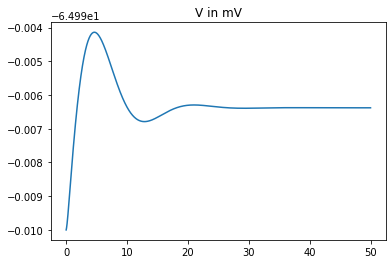

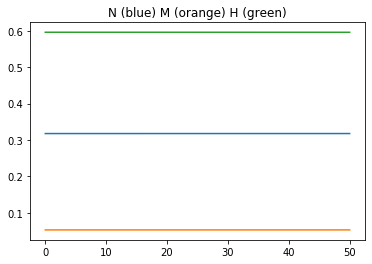

In [0]:
duration = 50.0 #ms
time_step = 0.01 #ms

I_e_over_A = np.full(np.ceil(duration/time_step).astype(int)+1, 0.0)
hhmodel = HHModel(duration, time_step, I_e_over_A)
hhmodel.integrate_exp()
hhmodel.plot()

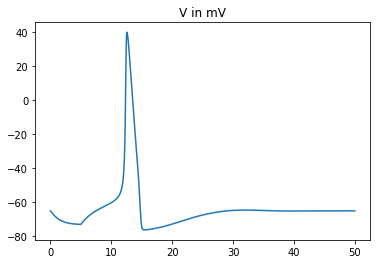

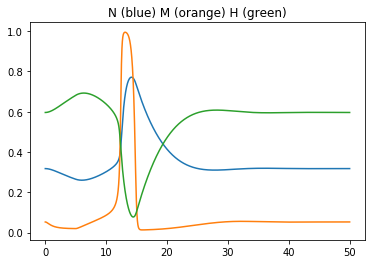

In [0]:
I_e_over_A[:np.ceil(5.0/time_step).astype(int)+1] = -50.0
hhmodel = HHModel(duration, time_step, I_e_over_A)
hhmodel.integrate_exp()
hhmodel.plot()

When no current is applied, n and m and h don't change and therefore V is also stable. When we set a constant Ie/A for 5 ms, we are moving n, m, h (and therefore V) away from their equilibrium (inf) values. Since they are by default trying to reach that, once the current is released, they gain enough momentum to "explode" into a spike before dying off to their equilibrium. That's why we get a spike.

This is to say that N M and H are given enough "space" such that when they are released to reach equilibrium, they do it quickly enough (derivative) that they generate the spike.